<h2><center><font color='blue'> Calculation of Well Head Protection Areas using Capture Zone Analysis </center></h2>

The use of Theis solution for capture zone analysis does not account for the impacts of regional groundwater flow gradients.  As such, other tools for better delineation of capture zones are available.  A schematic description of the capture zones is shown below




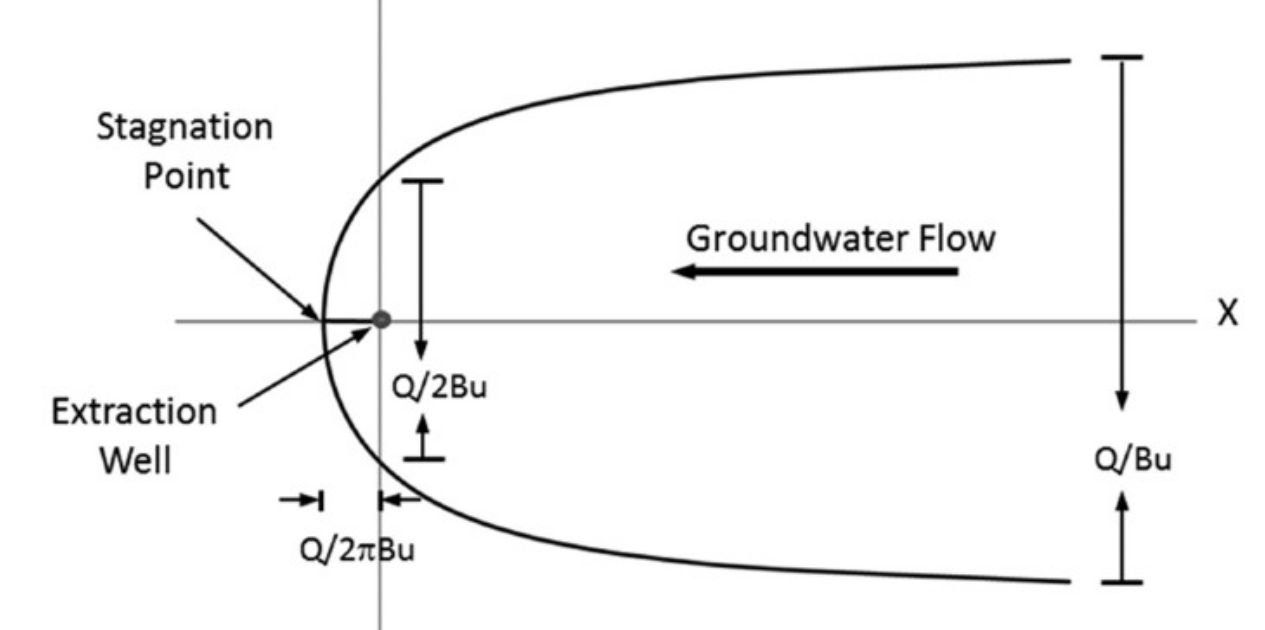

The figure above assumes the well is at a location (0,0).  The stagnation point refers to the point on the X-axis (downgradient of the flow) till which the pumping effects are felt.  The maximum width of the cpature zone along the Y-axis is also given.  We can also obtain the outer curve of the capture zone using the following equations.

$x_s = -\frac{Q}{2\pi BU} $  Where $x_s$ is the stagnation point.  Note as the well is at the origin, the stagnation point is negative

$y_{max} = \pm \frac{Q}{BU} $

For the capture zone boundary, the relationship between x and y is given as follows:

$ x = -\frac{y}{tan\left(\frac{2 \pi UB y}{Q}\right)} $

Where, U is the Darcy velocity (K.i) (ft/d); K is the hydraulic conductivity (ft/d); i is regional groundwater flow gradient.  Q is the pumping rate (ft$^3$/d); B is the aquifer thickness.  Note the product BU can also be written as the product Ti (where T is the aquifer transmissivity ft$^2$/d).  Note any set of consistent units can be used.  **If Albert Equal Area Conic** projection is used then the use of m for length dimension may come handy.  

<h4> Workflow

The computation entails the following steps.
<ol>
<li> Select the dimensions of study (L in m; t in Days); Q will be $m^3/d$ and BU = Ti = $m^2/d$ </li>
<li> Select projection to use.  Albers Equal Area Conic CONUS, NAD 83 (2011); EPSG:6350 </li>
<li> Select the Well Location (get lat-lon coordinates) convert to AEA projection </li>
<li> Extract Transmissivity values at the well (from interpolated T gpkg file) </li>
<li> Obtain the mean water levels (computed earlier) for wells in a gpkg fle </li>
<li> Convert the meam water levels file to AEA projection and compute X and Y coordinates </li>
<li> Compute the regional groundwater flow using linear regression of Hydraulic Head (from MSL) against X and Y </li>
<li> Use the coefficients of X and Y to obtain the gradients along X and Y axis and compute resultant gradient </li>
<li> Compute the capture zone polygon in model coordinates (well is at 0,0) </li>
<li> Convert the capture zone polygon to AEA projection coordinates use suitable transformation </li>
<li> Transform the coordinates obtained in the above step such that X-axis is oriented along the groundwater flow direction</li>
<li> Create a shapely polygon (object) of the capture zone.  Export to a gpkg file
<li> Overlay the capture zone polygon onto the Jefferson County Map; Embellish the plot as appropriate.
</ol>

<h4> Import Libraries

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import matplotlib_map_utils as mu # To draw north arrow
import statsmodels.api as sm
from matplotlib_scalebar.scalebar import ScaleBar # To draw scalebar
from mpl_toolkits.mplot3d import Axes3D

<h4> Set Working Directory

In [2]:
path = r"C:\Users\Prabin-PC\Downloads\MINIPROJECT\ASSIGNMENTS 2"
os.chdir(path)

<h4> Reading the files needed

In [3]:
file_pwells = 'PWELLS.gpkg'
file_jefferson_county = 'JeffersonCounty.gpkg'
file_gc_mean_water_level = 'GCMeanWaterLevel.csv'
file_selected_pwells = 'SelectedWells.csv'

<h3>Map of Selected Well (ID 6424502) in Jefferson County (EPSG:6350)</h3>
The code loads and transforms spatial data for selected wells and Jefferson County, then plots the location of a specific well (ID 6424502) within the county, using the EPSG:6350 coordinate reference system for accurate geographic representation.

C:\Users\Prabin-PC\AppData\Local\Temp\ipykernel_24640\1628095631.py:26: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


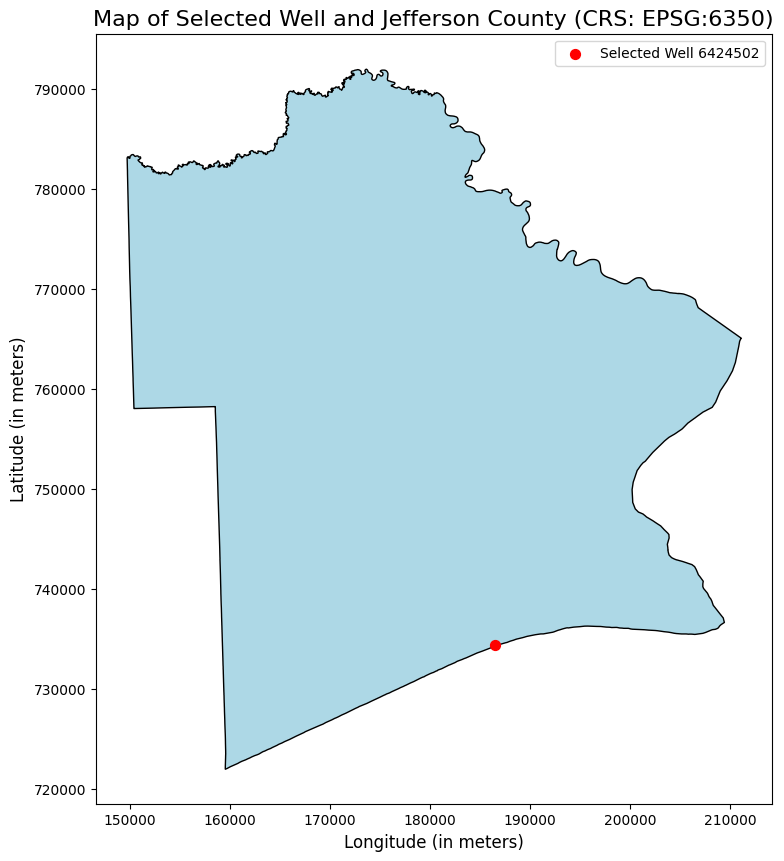

In [4]:
# Load GeoPackage files
selected_wells = gpd.read_file('PWELLS.gpkg')
jefferson_county = gpd.read_file('JeffersonCounty.gpkg')

# Convert both GeoDataFrames to EPSG:6350 (Albers Equal Area Conic CONUS, NAD83, 2011)
selected_wells = selected_wells.to_crs(epsg=6350)
jefferson_county = jefferson_county.to_crs(epsg=6350)

# Select well with StateWellNumber 6424502
well_id = 6424502
selected_well = selected_wells[selected_wells['StateWellNumber'] == well_id]

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Jefferson County (boundaries or other features)
jefferson_county.plot(ax=ax, color='lightblue', edgecolor='black', label='Jefferson County')

# Plot selected well(s) (points or other features)
selected_well.plot(ax=ax, color='red', markersize=50, label=f'Selected Well {well_id}')

# Add labels and title
plt.title('Map of Selected Well and Jefferson County (CRS: EPSG:6350)', fontsize=16)
plt.xlabel('Longitude (in meters)', fontsize=12)
plt.ylabel('Latitude (in meters)', fontsize=12)
plt.legend()

# Show the map
plt.show()

<h3> Set the CRS</h3>
The code reads well data from a GeoPackage, sets its CRS to WGS84, then transforms it to EPSG:6350 for better spatial analysis, and displays the GeoDataFrame.

In [5]:
# Read the GeoPackage file
Tvalues = gpd.read_file(file_pwells)

# Set the CRS for the GeoDataFrame, e.g., WGS84 (EPSG:4326)
Tvalues.set_crs(epsg=4326, inplace=True)

# Convert the CRS to Albers Equal Area Conic CONUS, NAD 83 (2011); EPSG:6350
Tvalues = Tvalues.to_crs(epsg=6350)

# Display the GeoDataFrame
print(Tvalues)

   StateWellNumber     County  LongitudeDD  LatitudeDD  \
0          6154901  Jefferson   -94.266112   30.134722   
1          6154905  Jefferson   -94.271389   30.159167   
2          6161602  Jefferson   -94.407223   30.073611   
3          6162303  Jefferson   -94.275555   30.089167   
4          6162305  Jefferson   -94.291667   30.096389   
5          6301301  Jefferson   -93.908612   29.968055   
6          6423201  Jefferson   -94.199722   29.742500   
7          6423302  Jefferson   -94.164167   29.741389   
8          6424502  Jefferson   -94.072778   29.667778   

   LandSurfaceElevationMethod  WellDepth  WaterElevation  DepthFromLSD  \
0  Interpolated From Topo Map       21.0       23.100000      6.900000   
1  Interpolated From Topo Map      572.0      -25.338571     51.338571   
2  Interpolated From Topo Map      300.0       29.300000      6.700000   
3  Interpolated From Topo Map      102.0       30.000000      8.000000   
4  Interpolated From Topo Map      208.0       31

In [6]:
Tvalues.columns

Index(['StateWellNumber', 'County', 'LongitudeDD', 'LatitudeDD',
       'LandSurfaceElevationMethod', 'WellDepth', 'WaterElevation',
       'DepthFromLSD', 'T_SQFTDay', 'T_GPD_ft', 'top_1', 'bot_1', 'bot_2',
       'bot_3', 'bot_4', 'bot_5', 'bot_6', 'geometry'],
      dtype='object')

<h3>Conversion of Transmissivity from ft²/day to m²/day</h3>
The Tvalues DataFrame is updated by converting transmissivity values from square feet per day (T_SQFTDay) to square meters per day (T_SQMPDay) using a conversion factor of 0.0929.

In [7]:
# Conversion factor from ft²/day to m2/day,conversion_factor = 0.0929
Tvalues['T_SQMPDay'] = Tvalues['T_SQFTDay'] * 0.0929
Tvalues['T_SQMPDay']

0    311.9582
1    311.4008
2    296.3510
3    309.9144
4    307.9635
5    301.6463
6    264.7650
7    269.5958
8    281.6728
Name: T_SQMPDay, dtype: float64

<h3>Calculation of Hydraulic Head Based on Water Elevation and Depth from LSD</h3>
The Tvalues DataFrame is being updated by calculating the Hydraulic Head. It is computed as the sum of the WaterElevation and DepthFromLSD for each well in the dataset

In [8]:
# Calculate Hydraulic Head assuming 'WaterElevation' and 'DepthFromLSD' provide enough info
Tvalues['HydraulicHead'] = Tvalues['WaterElevation'] + Tvalues['DepthFromLSD']
Tvalues

,StateWellNumber,County,LongitudeDD,LatitudeDD,LandSurfaceElevationMethod,WellDepth,WaterElevation,DepthFromLSD,T_SQFTDay,T_GPD_ft,top_1,bot_1,bot_2,bot_3,bot_4,bot_5,bot_6,geometry,T_SQMPDay,HydraulicHead
0,6154901,Jefferson,-94.266112,30.134722,Interpolated From Topo Map,21.0,23.100000,6.900000,3358,25120,7.84802,-7.15198,-423.0,-789.0,-986.0,-1533.111,-2221.0,POINT (166834.847 785849.276),311.9582,30.0
1,6154905,Jefferson,-94.271389,30.159167,Interpolated From Topo Map,572.0,-25.338571,51.338571,3352,25072,7.76283,-7.23717,-408.0,-750.0,-943.0,-1469.906,-2155.0,POINT (166277.794 788553.163),311.4008,26.0
2,6161602,Jefferson,-94.407223,30.073611,Interpolated From Topo Map,300.0,29.300000,6.700000,3190,23864,11.34370,-3.65630,-422.0,-844.0,-1033.0,-1528.316,-2262.0,POINT (153372.144 778829.428),296.3510,36.0
3,6162303,Jefferson,-94.275555,30.089167,Interpolated From Topo Map,102.0,30.000000,8.000000,3336,24952,11.82590,-3.17410,-438.0,-848.0,-1054.0,-1640.914,-2336.0,POINT (166018.091 780777.008),309.9144,38.0
4,6162305,Jefferson,-94.291667,30.096389,Interpolated From Topo Map,208.0,31.000000,8.000000,3315,24797,11.60230,-3.39770,-431.0,-818.0,-1030.0,-1596.809,-2295.0,POINT (164452.693 781550.465),307.9635,39.0
5,6301301,Jefferson,-93.908612,29.968055,Interpolated From Topo Map,1000.0,-3.320000,15.320000,3247,24288,2.47877,-12.52123,-483.0,-1290.0,-1482.0,-2222.534,-2918.0,POINT (201635.486 768048.647),301.6463,12.0
6,6423201,Jefferson,-94.199722,29.742500,Interpolated From Topo Map,178.0,1.800000,3.200000,2850,21316,1.58218,-13.41782,-572.0,-1373.0,-1586.0,-2462.670,-3265.0,POINT (174046.516 742456.471),264.7650,5.0
7,6423302,Jefferson,-94.164167,29.741389,Interpolated From Topo Map,70.0,1.900000,1.100000,2902,21712,1.53150,-13.46850,-576.0,-1401.0,-1614.0,-2465.575,-3288.0,POINT (177485.844 742399.036),269.5958,3.0
8,6424502,Jefferson,-94.072778,29.667778,Interpolated From Topo Map,10.0,2.000000,3.000000,3032,22684,1.78449,-13.21551,-630.0,-1534.0,-1772.0,-2645.063,-3526.0,POINT (186485.561 734412.408),281.6728,5.0


<h3>Selecting Well Data by Well ID (6424502)</h3>
The code filters the well data to select the record corresponding to the specified well ID (6424502) from the GeoDataFrame.

In [9]:
# Selected Well ID for the specified well
WID = 6424502
selected_wells = Tvalues.loc[Tvalues['StateWellNumber'] == WID]
selected_wells

,StateWellNumber,County,LongitudeDD,LatitudeDD,LandSurfaceElevationMethod,WellDepth,WaterElevation,DepthFromLSD,T_SQFTDay,T_GPD_ft,top_1,bot_1,bot_2,bot_3,bot_4,bot_5,bot_6,geometry,T_SQMPDay,HydraulicHead
8,6424502,Jefferson,-94.072778,29.667778,Interpolated From Topo Map,10.0,2.0,3.0,3032,22684,1.78449,-13.21551,-630.0,-1534.0,-1772.0,-2645.063,-3526.0,POINT (186485.561 734412.408),281.6728,5.0


<h3>Extracting Hydraulic Head for Well ID 6424502</h3>
The code filters the well data to select the well with the specified ID (6424502) and extracts its hydraulic head value for display.

In [10]:
# Select the well with the specified ID
well_id = 6424502
selected_well = selected_wells[selected_wells['StateWellNumber'] == well_id]

# Extract the hydraulic head for that well
hydraulic_head = selected_well['HydraulicHead'].values[0]  # Assuming 'HydraulicHead' is the column name

# Output the hydraulic head for the selected well
print(f"Hydraulic Head for Well ID {well_id}: {hydraulic_head}")

Hydraulic Head for Well ID 6424502: 5.0


<h3>Assigning Transmissivity Values to Selected Wells</h3>
The code assigns a specified transmissivity value to the selected wells in the GeoDataFrame, ensuring the number of values matches the number of wells. If they match, the values are added; if not, an error message is printed.

In [11]:
# Required Transmissivity values
T_SQMPDay = [281.6728]  

# Make sure the length matches the GeoDataFrame
if len(T_SQMPDay) == len(selected_wells):
    selected_wells['T_SQMPDay'] = T_SQMPDay
else:
    print("Length of transmissivity values does not match the number of rows in selected_wells.")


C:\Users\Prabin-PC\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<h3>Processing and Transforming Water Level Data for Hydraulic Head Calculation</h3>
This code loads water level data from a CSV file, converts geographic coordinates into a GeoDataFrame, transforms the CRS to EPSG:6350, and calculates the hydraulic head by combining water elevation and depth from the land surface datum. It then displays the first few rows of the transformed data.

In [12]:
# Load the CSV file
file_gc_mean_water_level = 'GCMeanWaterLevel.csv'
df = pd.read_csv(file_gc_mean_water_level)

# Create geometry from 'LongitudeDD' and 'LatitudeDD' columns
geometry = [Point(xy) for xy in zip(df['LongitudeDD'], df['LatitudeDD'])]

# Create a GeoDataFrame with the initial geometry
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Set the initial CRS to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

# Convert the CRS to Albers Equal Area Conic CONUS, NAD 83 (2011); EPSG:6350
gdf = gdf.to_crs(epsg=6350)

# Extract the transformed coordinates (X, Y) and add them as new columns
gdf['LONG6350'] = gdf.geometry.x
gdf['LAT6350'] = gdf.geometry.y

# Calculate 'Hydraulic_Head_MSL' using 'WaterElevation' and 'DepthFromLSD' columns
gdf['Hydraulichead'] = gdf['WaterElevation'] + gdf['DepthFromLSD']

# Display the first 5 rows
gdf.head(5)

,Unnamed: 0,StateWellNumber,County,LongitudeDD,LatitudeDD,LandSurfaceElevationMethod,WellDepth,WaterElevation,DepthFromLSD,geometry,LONG6350,LAT6350,Hydraulichead
0,0,6154901,Jefferson,-94.266112,30.134722,Interpolated From Topo Map,21.0,23.100000,6.900000,POINT (166834.847 785849.276),166834.846987,785849.276114,30.0
1,1,6154902,Jefferson,-94.271111,30.159167,Digital Elevation Model -DEM,450.0,-17.178889,45.178889,POINT (166304.523 788553.616),166304.522818,788553.615566,28.0
2,2,6154904,Jefferson,-94.270278,30.161667,Digital Elevation Model -DEM,530.0,-17.287143,44.287143,POINT (166379.619 788832.556),166379.619326,788832.555902,27.0
3,3,6154905,Jefferson,-94.271389,30.159167,Interpolated From Topo Map,572.0,-25.338571,51.338571,POINT (166277.794 788553.163),166277.793526,788553.162588,26.0
4,7,6155701,Jefferson,-94.213889,30.130555,Interpolated From Topo Map,68.0,27.000000,9.000000,POINT (171867.858 785479.863),171867.858370,785479.863195,36.0


<h3>Linear Regression Model for Hydraulic Head Prediction</h3>
This code uses a linear regression model to predict hydraulic head based on geographic coordinates (longitude and latitude). It fits the model, extracts coefficients, and calculates predicted values. The updated data, including the predictions, is saved to a new CSV file.

In [13]:
# Prepare the independent variables (X) and add a constant for the intercept
X = gdf[['LONG6350', 'LAT6350']]
X = sm.add_constant(X)  # Adds a constant term (intercept) to the model

# Define the dependent variable (Y)
Y = gdf['Hydraulichead']

# Fit the linear regression model
model = sm.OLS(Y, X).fit()

# Print the regression summary
print(model.summary())

# Extract the coefficients from the model
c, a, b = model.params

# Compute the predicted Hydraulic Head values
gdf['PredictedHH'] = model.predict(X)

# Save the updated GeoDataFrame as a CSV file
output_file = 'transformed_data_with_statsmodels_regression.csv'
gdf.to_csv(output_file, index=False)

                            OLS Regression Results                            
Dep. Variable:          Hydraulichead   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     146.7
Date:                Tue, 05 Nov 2024   Prob (F-statistic):           1.15e-38
Time:                        20:53:48   Log-Likelihood:                -631.25
No. Observations:                 185   AIC:                             1269.
Df Residuals:                     182   BIC:                             1278.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -267.3913     34.456     -7.760      0.0

In [14]:
gdf.head()

,Unnamed: 0,StateWellNumber,County,LongitudeDD,LatitudeDD,LandSurfaceElevationMethod,WellDepth,WaterElevation,DepthFromLSD,geometry,LONG6350,LAT6350,Hydraulichead,PredictedHH
0,0,6154901,Jefferson,-94.266112,30.134722,Interpolated From Topo Map,21.0,23.100000,6.900000,POINT (166834.847 785849.276),166834.846987,785849.276114,30.0,34.000510
1,1,6154902,Jefferson,-94.271111,30.159167,Digital Elevation Model -DEM,450.0,-17.178889,45.178889,POINT (166304.523 788553.616),166304.522818,788553.615566,28.0,35.562081
2,2,6154904,Jefferson,-94.270278,30.161667,Digital Elevation Model -DEM,530.0,-17.287143,44.287143,POINT (166379.619 788832.556),166379.619326,788832.555902,27.0,35.661523
3,3,6154905,Jefferson,-94.271389,30.159167,Interpolated From Topo Map,572.0,-25.338571,51.338571,POINT (166277.794 788553.163),166277.793526,788553.162588,26.0,35.574553
4,7,6155701,Jefferson,-94.213889,30.130555,Interpolated From Topo Map,68.0,27.000000,9.000000,POINT (171867.858 785479.863),171867.858370,785479.863195,36.0,31.431924


<h3>Use the coefficients of X and Y to obtain the gradients along X and Y axis and compute resultant gradient</h3>

The code calculates the pumping rate, hydraulic gradient, and transmissivity values for a well. It converts per capita water usage from gallons to cubic meters, computes the resultant gradient, and outputs the calculated values.

In [ ]:
# Given parameters
import numpy as np
Pop = 20000
pcu = 135  # gallons/d/capita
Q = Pop * pcu * 0.0037854117840007 # Pumping rate in cubic meter per day (m³/d), Conversion Factor 0.0037854117840007 from Gallor to Cubic Meter 
i = np.sqrt(a**2 + b**2)  # Resultant gradient
T = list(selected_wells.T_SQMPDay)  # T values in cubic meter per day
T = np.array(T)  # Convert the list to a numpy array
print(f"T : {T} m^3/day")
print(f"i : {i}")
print(f"Q : {Q} m^3/day")

The code calculates the magnitude and direction of a vector from its components \(a\) and \(b\), using the Pythagorean theorem for magnitude and the direction. The angle is converted from radians to degrees, and both the magnitude and direction are printed.

In [16]:
# Calculate the magnitude of the resultant vector
R = np.sqrt(a**2 + b**2)

# Calculate the direction of the resultant vector
theta = np.arctan2(b, a)  # atan2 is used to handle quadrant correctly

# Convert the angle from radians to degrees
theta_deg = np.degrees(theta)

# Output the results
print(f"Resultant Vector Magnitude (Hydraulic gradient): {R}")
print(f"Resultant Direction (in radians): {theta}")
print(f"Resultant Direction (in degrees): {theta_deg}")

Resultant Vector Magnitude (Hydraulic gradient): 0.0006782353452387308
Resultant Direction (in radians): 2.3462652553521353
Resultant Direction (in degrees): 134.43109674986172


<h3>Function to compute y-value and stagnation point</h3>

The code calculates the stagnation point, Y-value at the well, and the maximum width of the well's capture zone based on groundwater flow parameters like flow rate, transmissivity, and hydraulic gradient.

$x_s = -\frac{Q}{2\pi BU} $  Where $x_s$ is the stagnation point.  Note as the well is at the origin, the stagnation point is negative

$y_{max} = \pm \frac{Q}{BU} $

For the capture zone boundary, the relationship between x and y is given as follows:

$ x = -\frac{y}{tan\left(\frac{2 \pi UB y}{Q}\right)} $

In [32]:
# Calculate the stagnation point on the X-axis
pi = np.pi
x_stag = -Q / (2 * pi * T*i)

# Calculate the y-value at the extraction well
Y0 = (Q/(4*T*i)), -(Q/(4*T*i))

# Calculate the maximum width of the capture zone along the Y-axis
y_max = (Q/(2*T*i)), -(Q/(2*T*i))

# Print the result
print(f"Stagnation point (x_stag): {x_stag} m")
print(f"Maximum width of the capture zone (y_max): {y_max} m")
print(f"Y-value at the extraction well (Y_at the well): {Y0} m")

Stagnation point (x_stag): -8514.74597495345 m
Maximum width of the capture zone (y_max): (26749.86340209702, -26749.86340209702) m
Y-value at the extraction well (Y_at the well): (13374.93170104851, -13374.93170104851) m


<h3>Compute the capture zone polygon in model coordinates (well is at 0,0) </h3>
This code calculates and visualizes the Well Head Protection Areas using a specified boundary equation. It plots the well's protection area (based on the flow rate, hydraulic gradient, and transmissivity), marks the well's location at (0,0), and also highlights the stagnation point at a specific distance. The plot includes a grid and legend for clarity.

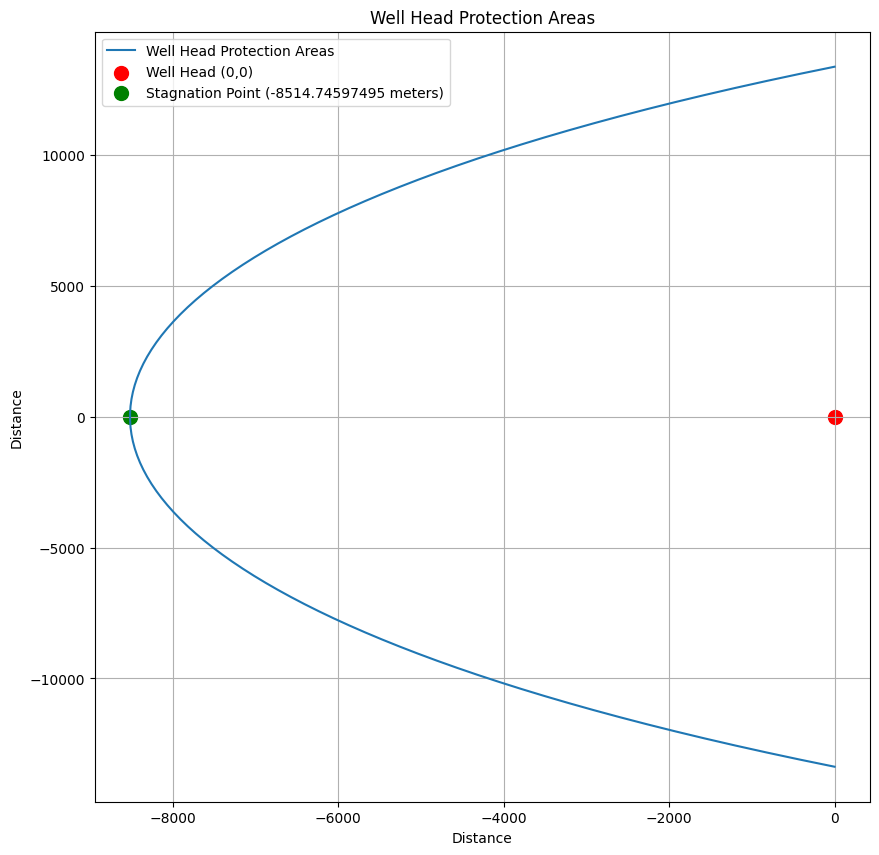

In [42]:
# Constants
T = 281.6728
i = 0.0006782353452387308
Q = 10220.611816801891  # Flow rate in cubic meters per day

# Define y range in meters and convert to kilometers for plotting
y = np.linspace(-13374.93170104851, 13374.93170104851, 100)  # y in meters

# Calculate x using the boundary equation
x = -y / np.tan((2 * np.pi * T*i * y) / Q)  # x in meters

# Plotting
plt.figure(figsize=(10, 10))
plt.plot(x, y, label='Well Head Protection Areas')
plt.xlabel('Distance')
plt.ylabel('Distance')
plt.title('Well Head Protection Areas')

# Marking the Well Head at (0,0)
plt.scatter(0, 0, color='red', s=100, label='Well Head (0,0)') 

# Marking the Stagnation Point, converting -8514.74597495 meters 
plt.scatter(-8514.74597495, 0, color='green', s=100, label='Stagnation Point (-8514.74597495 meters)') 

plt.grid(True)
plt.legend()
plt.show() 

<h3>3D Hydraulic Head and Gradient for well ID 6424502</h3> 
This code creates a 3D plot to visualize the hydraulic head at a specific well (Well ID 6424502) by plotting its longitude, latitude, and hydraulic head values. It includes a transparent surface representing the hydraulic head gradient around the well, and the plot is displayed with appropriate labels and a legend for easy interpretation. 

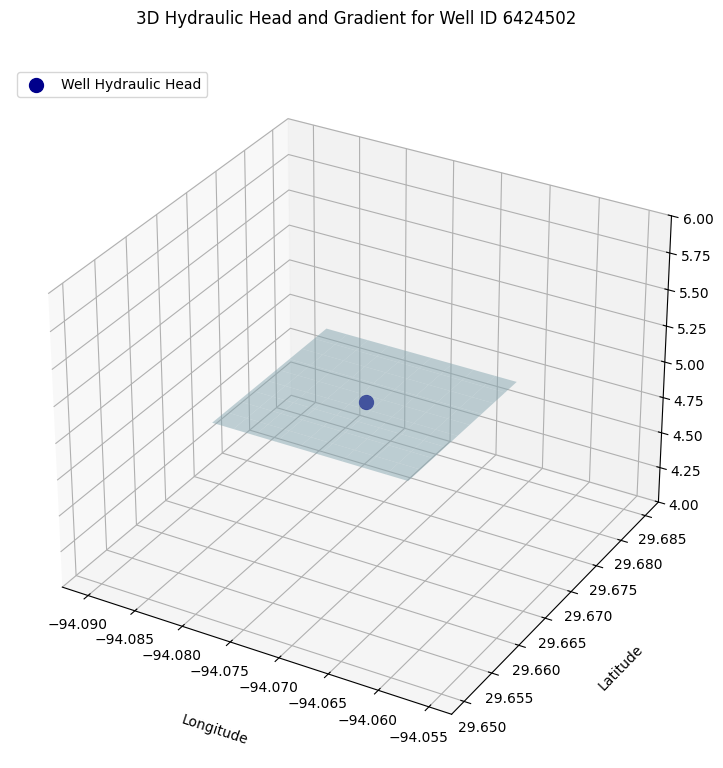

In [39]:
# Data for the specific well (Well ID 6424502)
longitude = -94.072778
latitude = 29.667778
hydraulic_head = 5.0
gradient = 0.0006782353452387308  # Example gradient value

# Prepare the data in arrays for plotting
longitude_vals = np.array([longitude])
latitude_vals = np.array([latitude])
hydraulic_head_vals = np.array([hydraulic_head])

# 3D Plot of the Hydraulic Head for the specific well
fig = plt.figure(figsize=(12, 9))  # Larger figure for more space
ax = fig.add_subplot(111, projection='3d')

# Plot the hydraulic head for the specific well in relation to Longitude and Latitude
scat = ax.scatter(longitude_vals, latitude_vals, hydraulic_head_vals, color='darkblue', marker='o', s=100, label='Well Hydraulic Head')

# Create a meshgrid for color transparency
x = np.linspace(longitude - 0.01, longitude + 0.01, 10)
y = np.linspace(latitude - 0.01, latitude + 0.01, 10)
X, Y = np.meshgrid(x, y)

# Z values will be hydraulic head for this case
Z = hydraulic_head * np.ones_like(X)

# Define light blue color for gradient layer
light_blue = (0.68, 0.85, 0.9, 0.3)  # RGBA for light blue with transparency

# Plot the transparent surface for the gradient with light blue
ax.plot_surface(X, Y, Z, color=light_blue, alpha=0.5, linewidth=0, rstride=1, cstride=1)

# Adjust the limits to give more room for labels and view
ax.set_xlim(longitude - 0.02, longitude + 0.02)
ax.set_ylim(latitude - 0.02, latitude + 0.02)
ax.set_zlim(hydraulic_head - 1, hydraulic_head + 1)

# Labels and title with additional padding
ax.set_xlabel('Longitude', labelpad=20)
ax.set_ylabel('Latitude', labelpad=20)
ax.set_zlabel('Hydraulic Head', labelpad=20)
ax.set_title(f'3D Hydraulic Head and Gradient for Well ID 6424502', pad=30)

# Show legend
plt.legend(loc="upper left")

# Show plot
plt.show()

<h3>Direction of GW flow from model origin to transformed origin.</h3>
This code transforms real-world well coordinates into model coordinates using a scaling factor, then plots the direction of groundwater flow from the model origin to the well location. It displays the well location and the flow direction in a scaled model coordinate system.

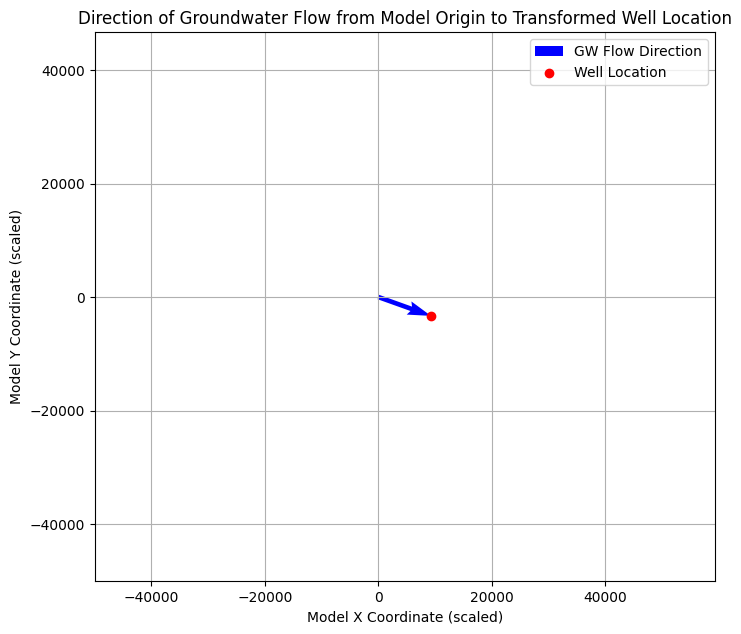

In [47]:
# Real-world coordinates of the well (actual values for the well location)
real_world_longitude = -94.072778
real_world_latitude = 29.667778

# Define the real-world origin (reference point) for the model at (e.g., -95.0, 30.0)
real_world_origin_longitude = -95.0
real_world_origin_latitude = 30.0

# Conversion factor to scale real-world units to model units
scale_factor = 10000  # Example scaling factor

# Calculate the offset between the well and the real-world origin
longitude_offset = real_world_longitude - real_world_origin_longitude
latitude_offset = real_world_latitude - real_world_origin_latitude

# Transform the real-world coordinates to model coordinates
well_model_x = longitude_offset * scale_factor
well_model_y = latitude_offset * scale_factor

# Model coordinates origin
model_origin = np.array([0, 0])

# Direction of groundwater (GW) flow vector
gw_direction_vector = np.array([well_model_x, well_model_y]) - model_origin

# Plotting the direction of GW flow
plt.figure(figsize=(8, 8))

# Plot the direction of GW flow from model origin to the well
plt.quiver(model_origin[0], model_origin[1], gw_direction_vector[0], gw_direction_vector[1],
           angles='xy', scale_units='xy', scale=1, color='blue', label='GW Flow Direction')

# Plot the well location in model coordinates
plt.scatter(well_model_x, well_model_y, color='red', label='Well Location')

# Labels and title
plt.xlabel("Model X Coordinate (scaled)")
plt.ylabel("Model Y Coordinate (scaled)")
plt.title("Direction of Groundwater Flow from Model Origin to Transformed Well Location")
plt.legend()

# Set axis limits to fit all elements comfortably
plt.xlim(model_origin[0] - 50000, well_model_x + 50000)
plt.ylim(model_origin[1] - 50000, well_model_y + 50000)

# Show plot
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

<h3>Transform the coordinates obtained in the above step such that X-axis is oriented along the groundwater flow direction</h3>
This code calculates and plots the **Well Head Protection Area** for a groundwater well, showing the well location, protection boundary, stagnation point, and a capture zone. It uses flow equations to visualize the impacted area, with clear labeling and a legend.

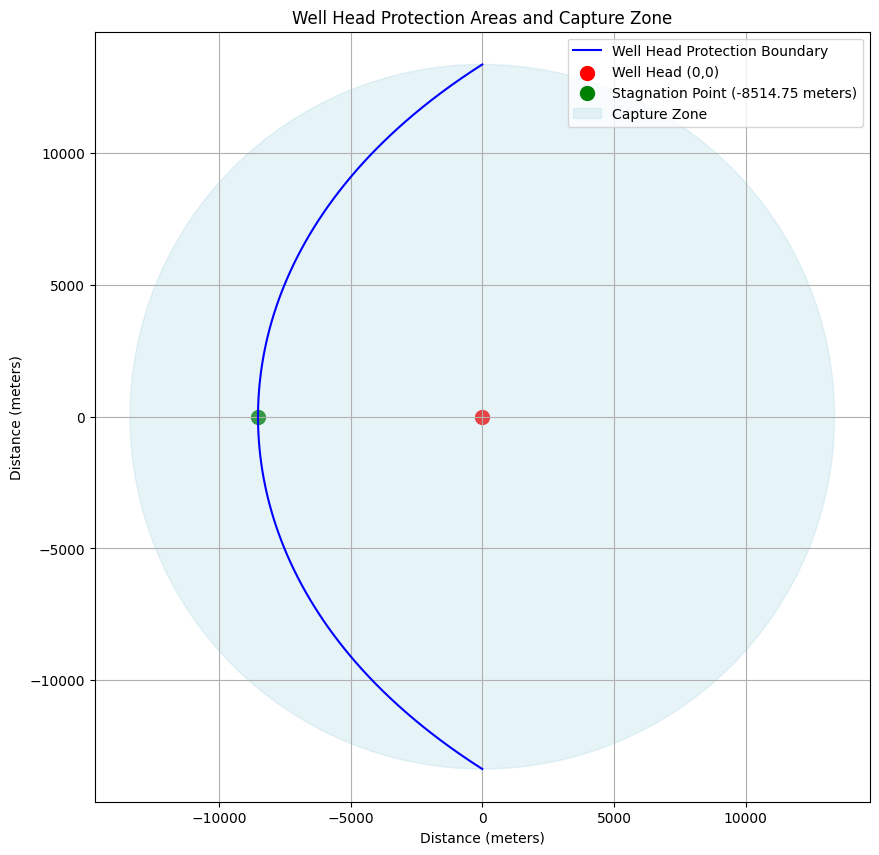

In [49]:
# Constants
T = 281.6728  # Transmissivity in square meters per day
i = 0.0006782353452387308  # Hydraulic gradient
Q = 10220.611816801891  # Flow rate in cubic meters per day

# Define y range in meters (convert to kilometers for plotting if needed)
y = np.linspace(-13374.93170104851, 13374.93170104851, 100)  # y in meters

# Calculate x using the boundary equation
x = -y / np.tan((2 * np.pi * T * i * y) / Q)  # x in meters

# Plotting Well Head Protection Areas and Capture Zone
plt.figure(figsize=(10, 10))
plt.plot(x, y, label='Well Head Protection Boundary', color='blue')
plt.xlabel('Distance (meters)')
plt.ylabel('Distance (meters)')
plt.title('Well Head Protection Areas and Capture Zone')

# Marking the Well Head at (0,0)
plt.scatter(0, 0, color='red', s=100, label='Well Head (0,0)') 

# Marking the Stagnation Point
stagnation_point_x = -8514.74597495  # in meters
plt.scatter(stagnation_point_x, 0, color='green', s=100, label='Stagnation Point (-8514.75 meters)')

# Adding Capture Zone (e.g., an approximation)
capture_zone_radius = 13374.93170104851  # defined as half the y-range for visualization
capture_circle = plt.Circle((0, 0), capture_zone_radius, color='lightblue', alpha=0.3, label='Capture Zone', zorder=1)
plt.gca().add_patch(capture_circle)

# Final plot adjustments
plt.grid(True)
plt.legend(loc='upper right')  # Set legend location to top-right corner
plt.axis('equal')  # Make x and y scales equal for accurate representation
plt.show()

<h3>Create a shapely polygon (object) of the capture zone.</h3>  
This script will generate a GeoPackage file, capture_zone_6424502.gpkg, containing a single layer with the capture zone polygon for Well ID 6424502.

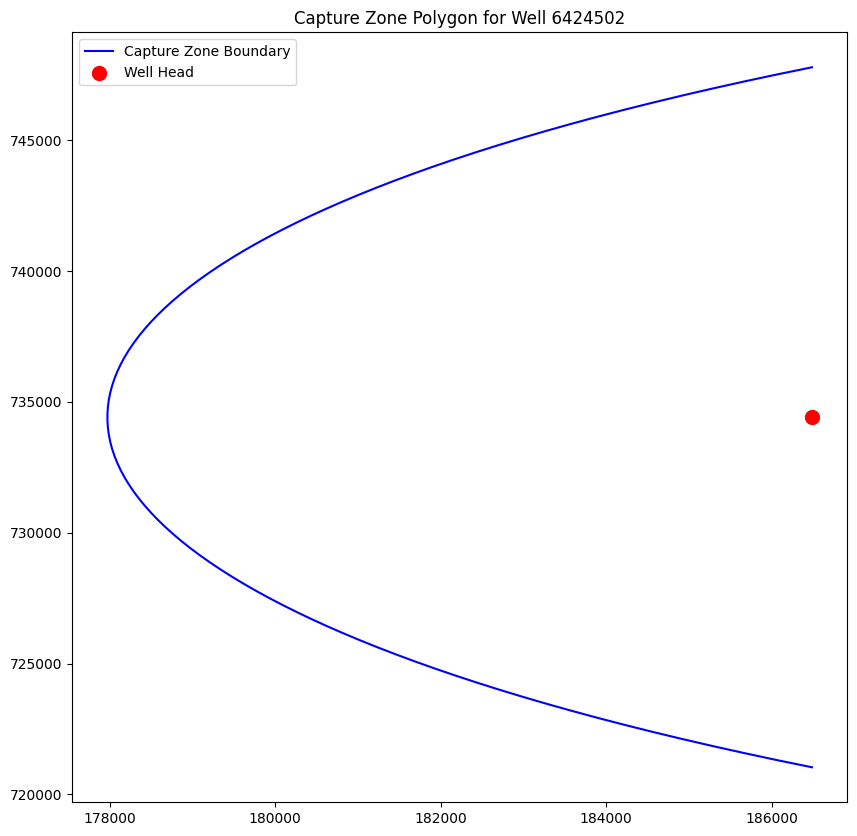

Capture zone polygon exported to capture_zone_6424502.gpkg


In [53]:
# Constants for capture zone calculation
T = 281.6728  # Transmissivity in square meters per day
i = 0.0006782353452387308  # Hydraulic gradient
Q = 10220.611816801891  # Flow rate in cubic meters per day

# Define y range in meters
y = np.linspace(-13374.93170104851, 13374.93170104851, 100)  # y in meters

# Calculate x using the boundary equation
x = -y / np.tan((2 * np.pi * T * i * y) / Q)  # x in meters

# Load GeoPackage file for selected well data
selected_wells = gpd.read_file('PWELLS.gpkg')
selected_wells = selected_wells.to_crs(epsg=6350)  # Ensure CRS matches EPSG:6350

# Select well with StateWellNumber 6424502
well_id = 6424502
selected_well = selected_wells[selected_wells['StateWellNumber'] == well_id]

# Get the coordinates for the selected well
well_point = selected_well.geometry.iloc[0]
well_x, well_y = well_point.x, well_point.y

# Calculate capture zone coordinates relative to the well location
capture_zone_x = x + well_x
capture_zone_y = y + well_y

# Combine x and y into points and create a Polygon
capture_zone_boundary_points = list(zip(capture_zone_x, capture_zone_y))
capture_zone_polygon = Polygon(capture_zone_boundary_points)

# Plotting for visualization (optional)
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(capture_zone_x, capture_zone_y, label='Capture Zone Boundary', color='blue')
plt.scatter(well_x, well_y, color='red', s=100, label='Well Head')
plt.title("Capture Zone Polygon for Well 6424502")
plt.legend()
plt.show()

# Create a GeoDataFrame for export
capture_zone_gdf = gpd.GeoDataFrame({'well_id': [well_id], 'geometry': [capture_zone_polygon]}, crs='EPSG:6350')

# Export to a GPKG file
capture_zone_gdf.to_file('capture_zone_6424502.gpkg', layer='CaptureZone', driver='GPKG')

print("Capture zone polygon exported to capture_zone_6424502.gpkg")

<h3> Overlay the capture zone polygon onto the Jefferson County Map; Embellish the plot as appropriate.</h3>
The code visualizes the groundwater flow around a well in Jefferson County, displaying the well's location, a capture zone (protected area), and a stagnation point on a map. It calculates the protection boundary based on the well's water intake parameters and plots everything on a map for easy interpretation.

C:\Users\Prabin-PC\AppData\Local\Temp\ipykernel_24640\3517244763.py:55: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper right')


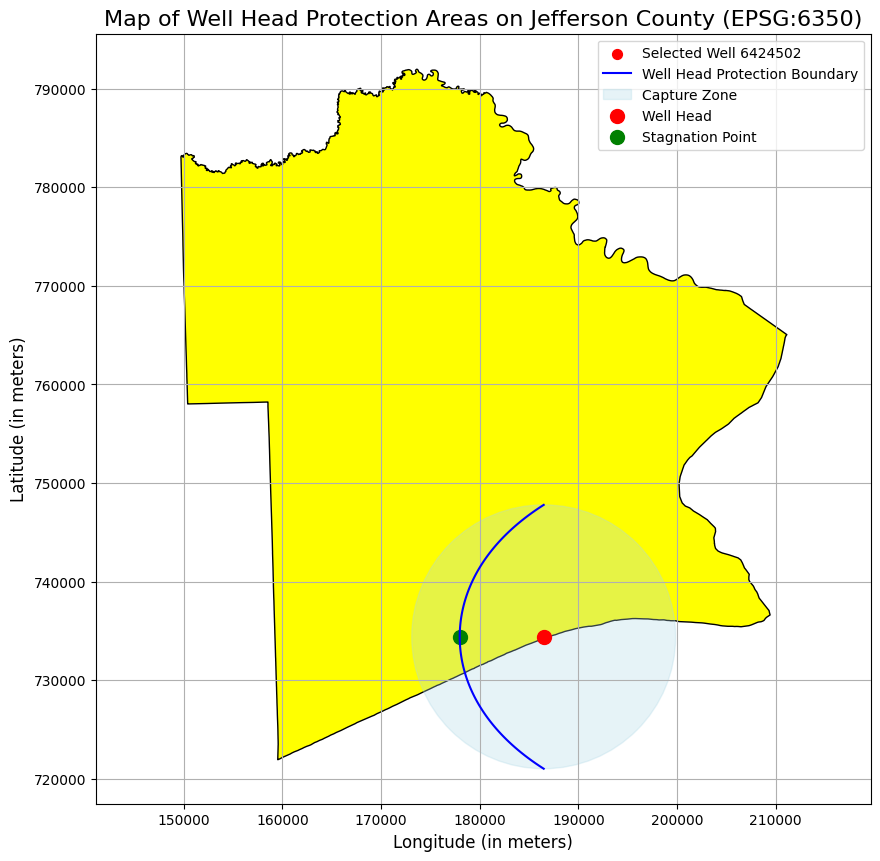

In [57]:
# Constants
T = 281.6728  # Transmissivity in square meters per day
i = 0.0006782353452387308  # Hydraulic gradient
Q = 10220.611816801891  # Flow rate in cubic meters per day

# Define y range in meters
y = np.linspace(-13374.93170104851, 13374.93170104851, 100)  # y in meters

# Calculate x using the boundary equation
x = -y / np.tan((2 * np.pi * T * i * y) / Q)  # x in meters

# Load GeoPackage files for Jefferson County and Wells
selected_wells = gpd.read_file('PWELLS.gpkg')
jefferson_county = gpd.read_file('JeffersonCounty.gpkg')

# Convert both GeoDataFrames to EPSG:6350 (Albers Equal Area Conic CONUS, NAD83, 2011)
selected_wells = selected_wells.to_crs(epsg=6350)
jefferson_county = jefferson_county.to_crs(epsg=6350)

# Select the well with StateWellNumber 6424502
well_id = 6424502
selected_well = selected_wells[selected_wells['StateWellNumber'] == well_id]

# Extract the well's coordinates for the capture zone overlay
well_point = selected_well.geometry.iloc[0]
well_x, well_y = well_point.x, well_point.y

# Create the capture zone coordinates relative to well location
capture_zone_x = x + well_x
capture_zone_y = y + well_y

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Jefferson County boundaries
jefferson_county.plot(ax=ax, color='yellow', edgecolor='black', label='Jefferson County')

# Plot selected well(s)
selected_well.plot(ax=ax, color='red', markersize=50, label=f'Selected Well {well_id}')

# Overlay capture zone
ax.plot(capture_zone_x, capture_zone_y, label='Well Head Protection Boundary', color='blue')
capture_zone_radius = 13374.93170104851  # Approximation for visualization
capture_circle = plt.Circle((well_x, well_y), capture_zone_radius, color='lightblue', alpha=0.3, label='Capture Zone', zorder=1)
ax.add_patch(capture_circle)

# Plotting well and stagnation point markers
ax.scatter(well_x, well_y, color='red', s=100, label='Well Head')
ax.scatter(well_x - 8514.74597495, well_y, color='green', s=100, label='Stagnation Point')

# Add labels, title, and legend
plt.title('Map of Well Head Protection Areas on Jefferson County (EPSG:6350)', fontsize=16)
plt.xlabel('Longitude (in meters)', fontsize=12)
plt.ylabel('Latitude (in meters)', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True)

# Ensure equal scaling
plt.axis('equal')

# Show the map
plt.show()